In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('final_data.csv')

/var/folders/p1/4t2ts09s1pg1p6xt550h6jp80000gn/T/ipykernel_34706/3194845066.py:1: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('final_data.csv')


In [3]:
for col in data.select_dtypes(include=['object']).columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# 检查转换后的数据类型
print(data.dtypes)

airline_type                                    int64
FlightDuration_Minutes                        float64
DepAirport                                      int64
ArrAirport                                      int64
DayOfWeek                                       int64
CRSTimeOfDay_Dep                                int64
CRSTimeOfDay_Arr                                int64
Month                                           int64
CRSDepTime_Origin_skycond                     float64
CRSArrTime_Dest_skycond                       float64
CRSDepTime_Origin_HourlyRelativeHumidity      float64
CRSArrTime_Dest_HourlyRelativeHumidity        float64
CRSDepTime_Origin_HourlyDryBulbTemperature    float64
CRSArrTime_Dest_HourlyDryBulbTemperature      float64
CRSDepTime_Origin_HourlyWindSpeed             float64
CRSArrTime_Dest_HourlyWindSpeed               float64
CRSDepTime_Origin_HourlyVisibility            float64
CRSArrTime_Dest_HourlyVisibility              float64
Cancelled                   

In [4]:
print(data['Cancelled'].value_counts())

Cancelled
0    8048772
1     100060
Name: count, dtype: int64


In [5]:
print(data['Cancelled'].value_counts())

Cancelled
0    8048772
1     100060
Name: count, dtype: int64


In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 定义延误条件和对应的类别
conditions = [
   
    (data['ArrDelay'] > 45),
    (data['ArrDelay'] > 15) & (data['ArrDelay'] <= 45),
    (data['ArrDelay'] > 0) & (data['ArrDelay'] <= 15),
    (data['ArrDelay'] >= -15) & (data['ArrDelay'] <= 0),
    (data['ArrDelay'] >= -45) & (data['ArrDelay'] < -15),
    (data['ArrDelay'] < -45),

   
]

choices = [
    'large delay',    # > 45
  
    'medium delay',       # 15-45
    'small delay',          # 0 ~15
    'small early',          # -15 ~ -0
    'medium early',       # -45 ~ -15
    'large early'     # < -45
]

# 创建新特征 'Delay_type'，Cancelled 为 0 时设置为 'Cancelled'，否则根据 ArrDelay 分类
data['Delay_type'] = np.where(
    data['Cancelled'] == 1,
    'Cancelled',
    np.select(conditions, choices, default='unknown')
)

# 初始化 LabelEncoder 并对 'Delay_type' 进行编码
label_encoder = LabelEncoder()
data['Delay_type_encoded'] = label_encoder.fit_transform(data['Delay_type'])

# 查看编码结果和编码的映射关系

print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{'Cancelled': 0, 'large delay': 1, 'large early': 2, 'medium delay': 3, 'medium early': 4, 'small delay': 5, 'small early': 6, 'unknown': 7}


In [7]:
data = data[data['Delay_type'] != 'unknown'].reset_index(drop=True)

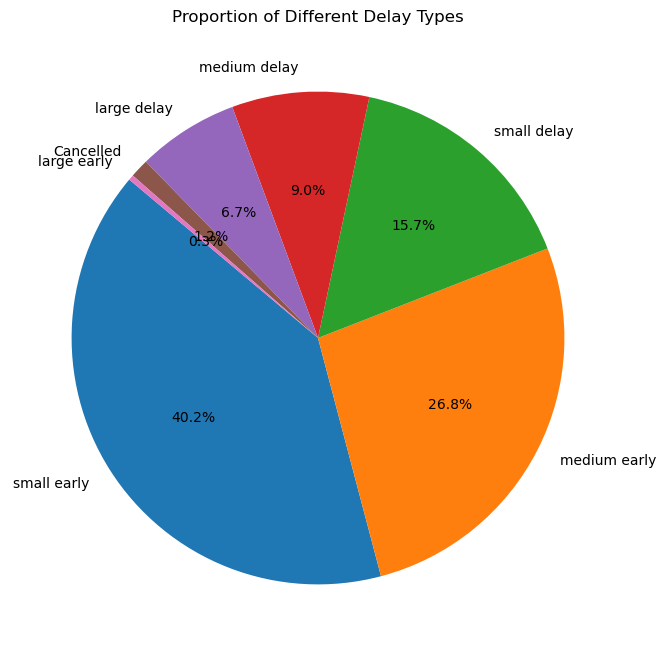

In [20]:
import matplotlib.pyplot as plt

# 计算各类别的数量
category_counts = data['Delay_type'].value_counts()

# 绘制饼图
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Different Delay Types')
plt.savefig('ProportionOfDiffrentDelayTypes.png', format='png', dpi=300)  

plt.show()


In [9]:
category_counts = data['Delay_type'].value_counts()
category_percentages = (category_counts / len(data)) * 100

# 创建一个包含类别、数量和百分比的表格
category_summary = pd.DataFrame({
    'Count': category_counts,
    'Percentage (%)': category_percentages
})

# 输出结果
print(category_summary)

                Count  Percentage (%)
Delay_type                           
small early   3272647       40.225793
medium early  2180954       26.807231
small delay   1280072       15.734025
medium delay   732262        9.000610
large delay    541237        6.652623
Cancelled      100060        1.229889
large early     28461        0.349829


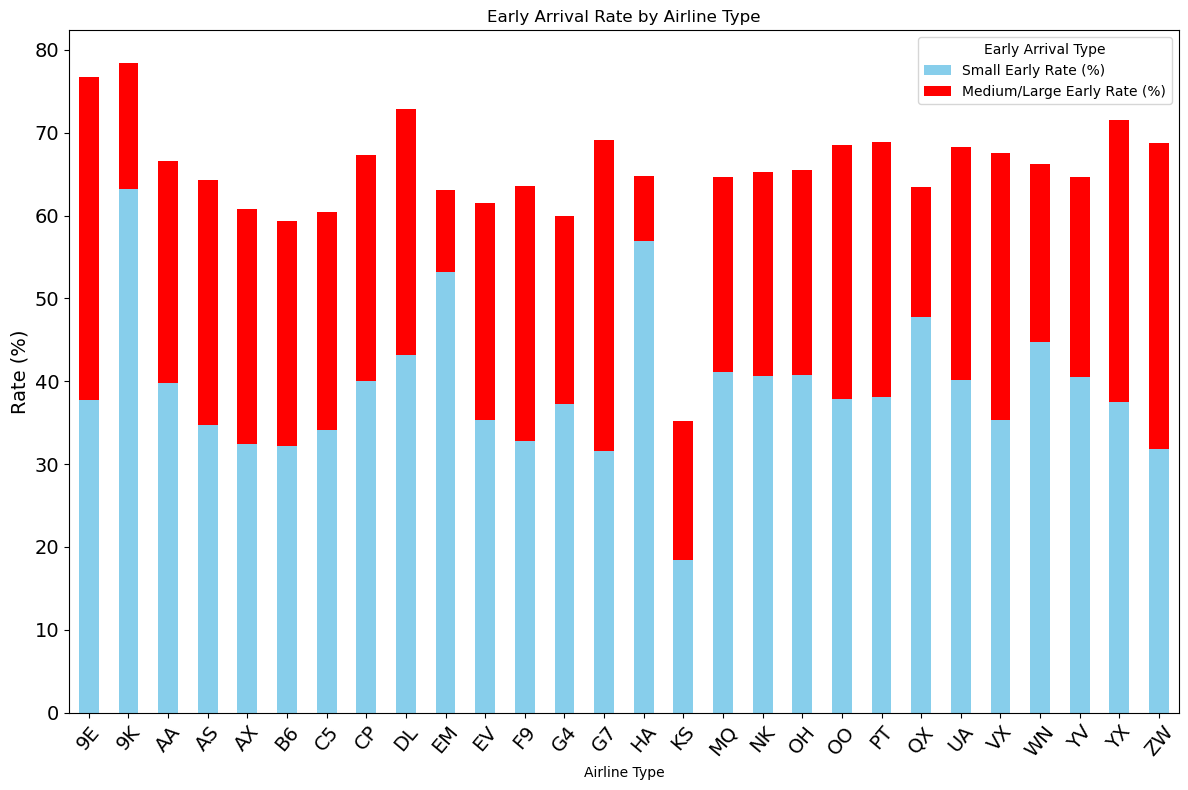

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

airline_mapping = {
    0: '9E', 1: '9K', 2: 'AA', 3: 'AS', 4: 'AX', 5: 'B6', 6: 'C5', 7: 'CP', 8: 'DL',
    9: 'EM', 10: 'EV', 11: 'F9', 12: 'G4', 13: 'G7', 14: 'HA', 15: 'KS', 16: 'MQ',
    17: 'NK', 18: 'OH', 19: 'OO', 20: 'PT', 21: 'QX', 22: 'UA', 23: 'VX', 24: 'WN',
    25: 'YV', 26: 'YX', 27: 'ZW'
}

data['airline_type_2'] = data['airline_type'].map(airline_mapping)

# Filter data for early arrivals only (small early and medium early)
early_arrivals = data[data['Delay_type'].isin(['small early', 'medium early', 'large early'])]

# Calculate the rate of each type of early arrival for each airline type
# Get the total flights for each airline
total_flights_per_airline = data['airline_type_2'].value_counts()

# Count the number of small early and medium early flights for each airline
small_early_counts = early_arrivals[early_arrivals['Delay_type'] == 'small early']['airline_type_2'].value_counts()
medium_large_early_counts = early_arrivals[early_arrivals['Delay_type'].isin(['medium early', 'large early'])]['airline_type_2'].value_counts()

# Calculate the rates
small_early_rate = (small_early_counts / total_flights_per_airline) * 100
medium_large_early_rate = (medium_large_early_counts / total_flights_per_airline) * 100

# Combine the rates into a DataFrame for plotting
early_rates_df = pd.DataFrame({
    'Small Early Rate (%)': small_early_rate,
    'Medium/Large Early Rate (%)': medium_large_early_rate
}).fillna(0)  # Fill NaN values with 0 for airlines with no early arrivals

# Plot the histogram
early_rates_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=['skyblue', 'red'])
plt.title('Early Arrival Rate by Airline Type')
plt.xlabel('Airline Type')
plt.ylabel('Rate (%)', fontsize=14)
plt.xticks(rotation=50, fontsize=14)
plt.yticks(fontsize=14) 
plt.legend(title='Early Arrival Type')
plt.tight_layout()
plt.savefig('EarlyArrByAirlineType.png', format='png', dpi=300)  

plt.show()


In [ ]:
from collections import Counter

# 删除 X 中包含 NaN 值的行
X = data.drop(columns=['Cancelled','ArrDelay','Delay_type','Delay_type_encoded'])  # 特征
y = data['Delay_type_encoded']  # 目标

# 删除 X 中的 NaN 行，并保持 y 与 X 的行数一致
X = X.dropna()
y = y.loc[X.index]  # 使用 `loc` 保证 y 与 X 的索引对齐

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Feature importance plot
feature_importances = rf_classifier.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance in Random Forest")
plt.show()
